# Kaggle GI Tract Inference 2

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer




**Notes**
* 


In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from tqdm import tqdm

from torchvision.transforms import PILToTensor
from torchvision import transforms
from torch.nn import functional as F


ROOT_FOLDER = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/'
MODEL_FOLDER = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models'

model_file_base = 'Unet-2-2.pth'
n_folds = 5

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

# Data

## Process the Test files

#### this script is for debugging locally and uses the training data
`debug = True` will result in using all the training images to do inference and also do a check on the resize+ pad transform needed to invert the basic training transform  (crop+resize)

In [2]:
debug = True

In [3]:

test_fnames = glob.glob("{}train/*/*/scans/*.png".format(ROOT_FOLDER))
file_df = pd.DataFrame(test_fnames)
#file_df = file_df[:200*3]

### Get the filenames for the test files and make a dataframe for inference



In [4]:

print("Samples to predict:",len(file_df))

Samples to predict: 38496


In [5]:
file_df.columns = ["path"]

We need to submit a csv with the following columns

In [6]:
sub_df = pd.read_csv(ROOT_FOLDER+'/sample_submission.csv')

In [7]:
sub_df.columns

Index(['id', 'class', 'predicted'], dtype='object')

We need a way to get the `id` for the submission from the file paths

Build a function that does the string manipulation

In [8]:
def id_from_path(p):
    
    #p = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case24/case24_day25/scans/slice_0046_266_266_1.50_1.50.png'
    s1 = p.split('/')
    filename = s1[-1] # 'slice_0046_266_266_1.50_1.50.png'
    case_day_str = s1[-3] # 'case24_day25'
    slice_str = '_'.join(filename.split('_')[-7:-4]) #'slice_0046'
    id_str = case_day_str + '_' + slice_str #'case24_day25_slice_0046'
    return id_str
    
    

In [9]:
file_df["id"] = file_df["path"].apply(id_from_path)

In [10]:
file_df

path  \
0      /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
1      /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
2      /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
3      /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
4      /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
...                                                  ...   
38491  /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
38492  /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
38493  /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
38494  /media/SSD/gi-tract/uw-madison-gi-tract-image-...   
38495  /media/SSD/gi-tract/uw-madison-gi-tract-image-...   

                            id  
0      case24_day25_slice_0046  
1      case24_day25_slice_0099  
2      case24_day25_slice_0013  
3      case24_day25_slice_0064  
4      case24_day25_slice_0090  
...                        ...  
38491   case29_day0_slice_0049  
38492   case29_day0_slice_0079  
38493   case29_day0_slice_0093  
38494   case29_day0_slice_0119  
38495   case29_day0_slice_0043  

[38496 rows x 2 columns]

## Get the NN Models

For each fold of the data we have a model, so we need to get all of them.  They are not huge so we can keep all of them in the GPU.

In [11]:
models = []
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # don't need initialization since we will load our models
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER+ "/" + "fold-" + str(fold) + '-' + model_file_base 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()
    models.append(model)
    

/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-2-2.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-2-2.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-2-2.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-2-2.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-2-2.pth


## Create a Pytorch Dataset for inference

The main difference relative to training is we don't have the ground truth run length encoded mask.
We also provide the `id` used in the submission because its the key

In [126]:
class Dataset_from_df_inference(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
        
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        print('test:',idx)
        
        img_path = row.path
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        
        
        # capture the shape of the original image because we want our final mask
        # used for RLE to match this shape
        mask_shape = img.shape

        
        
        # resize our image to a consistent size to provide as input to model
        if self.transform:
            img = self.transform(img)
    
        
        
        return {
            "image": img,
            "mask_shape": mask_shape,
            "id": row.id #return the row id used in the submission
        }
        
        
    
    


### Define our transform
We use the basic imaging sizing from Training because that recreates the conditions under which we trained

In [13]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')  

In [14]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

In [172]:
scale_transforms = transforms.Compose(
    [squarepad_transform,
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((320,320),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

### Create the Dataset
And ensure it returns what we expect

In [173]:
test_dataset = Dataset_from_df_inference(file_df,scale_transforms)

In [17]:
test_dataset[0]['mask_shape'], test_dataset[0]['id']

(torch.Size([1, 266, 266]), 'case24_day25_slice_0046')

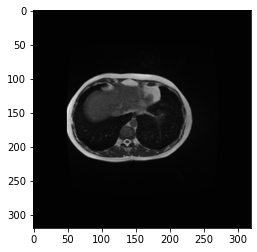

In [18]:
plt.imshow(test_dataset[0]['image'].squeeze().numpy(),cmap='gray')

## Inference Processing

Create the dataloader. Kaggle reccommends `num_workers=2` when using the GPU.  We may have to change the `batch_size` and `pin_memory` settings for Kaggle virtual machine.

In [19]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=16,
                                               num_workers=2,
                                               pin_memory=True, #pagelock the memory for faster loads to GPU RAM
                                               shuffle=False)

In [20]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Threshold for turning the masking image prediction into an image with pixels of 0 or 1 per channel
Reflects how high we need the predicted probababilty before we count the pixel in the mask
Also the image resizing impacts the mask edges (we use bicubic interpolation to avoid some of this) so a lower threshold might be needed to have the masks with pixels of 0 or 1 register edges better.

Should be between 0 and 1.0, on the higher side.

In [21]:

threshold = .8

Loop through our test data and create the submission

In [22]:
sub = {'id':[], 'class':[], 'predicted':[]} # a dict to store our submission
pbar = tqdm(total=len(test_dataloader))


for batch in test_dataloader:
    
    images = batch['image'].to(DEVICE)
    mask_shape = batch['mask_shape']
    ids = batch['id']
    

    #Take each of our fold models and average the outputs together
    with torch.no_grad():
        output = models[0](images)
        output = torch.nn.Sigmoid()(output) / n_folds
        mask = output
        for i in range(1,n_folds):
            output = models[i](images)
            output = torch.nn.Sigmoid()(output) / n_folds
            mask = mask + output
    
    #print("1", mask.shape)


    #From here we need to apply the invert of the the basic image crop and resize exactly to the mask image
    #and then apply run length encoding to that image
    
    mask = transforms.Resize((360,360),interpolation=transforms.InterpolationMode.BICUBIC)(mask) # undo resize to 288x288
    #print("3", mask.shape)
    
    #print('4',mask_shape)
    
    
    # Since we are processing a batch, the final mask shape may change within a batch
    # So we can't store that as a 1 tensor per batch
    # Need to process each batch item individually from here

    #single_mask = torch.zeros_like(mask[0])
    batch_size = mask.shape[0]  # need to get for each batch since last batch may smaller
    for b in range(0,batch_size):
        
        #plt.imshow(rearrange(mask[b].cpu().detach().numpy(),'c h w -> h w c'))
        #print('here',(mask_shape[1][b].item(),mask_shape[2][b].item()))
        
        
        single_mask = transforms.functional.center_crop(mask[b],(mask_shape[1][b].item(),mask_shape[2][b].item()))
        
        #print("5", single_mask.shape)
            
        single_mask = (single_mask > threshold)*1.0  # Run Length encoding requires a mask with 0 or 1
        single_mask = single_mask.cpu().detach().numpy() # go from a tensor on the GPU to a numpy on CPU

        #plt.imshow(rearrange(single_mask,'c h w -> h w c'))
        # create 3 submission rows, one for each organ
        sub_id = ids[b] #get the submission id from the batch
        
        large_bowel = rle_encode(single_mask[0])
        sub['id'].append(sub_id)
        sub['class'].append('large_bowel')
        sub['predicted'].append(large_bowel)

        small_bowel = rle_encode(single_mask[1])
        sub['id'].append(sub_id)
        sub['class'].append('small_bowel')
        sub['predicted'].append(small_bowel)

        stomach = rle_encode(single_mask[2])
        sub['id'].append(sub_id)
        sub['class'].append('stomach')
        sub['predicted'].append(stomach)    

    

        
   
    pbar.update(1)
    #break
pbar.close()
torch.cuda.empty_cache()


100%|███████████████████████████████████████| 2406/2406 [13:07<00:00,  3.06it/s]


### Create predictions

In [23]:
pred_df = pd.DataFrame(sub)

In [24]:
sel = pred_df['predicted'] ==''

In [25]:
pred_df[~sel]

Empty DataFrame
Columns: [id, class, predicted]
Index: []

In [26]:
mask.min(), mask.max()

(tensor(-3.2799e-06, device='cuda:0'), tensor(0.0001, device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


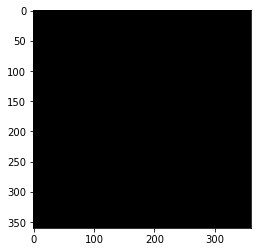

In [27]:
plt.imshow(rearrange(mask[0].cpu().detach().numpy(),'c h w -> h w c'))

## Trial inferences

### set up training dataloader

In [184]:
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, joint_transform=None, image_transform=None, mask_transform=None):
        self.df = df
        self.path = path
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        print('train:',idx)
        
        img_path = self.path/row.subpath
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach
        
        
        mask = torch.zeros((3, img.shape[1], img.shape[2]))

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,img.shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, img.shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, img.shape,color_val=1)
        
 
        if self.image_transform:
            img = self.image_transform(img)
            
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        
        if self.joint_transform:            
            image_stack = torch.cat([img, mask], dim=0)
            image_stack = self.joint_transform(image_stack)
            img = image_stack[0:1]
            mask = image_stack[1:4]
        

    
        
        return {
            "image": img,
            "mask": mask,
        }
        
        
    
    


In [185]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

In [186]:
scaling_transforms = transforms.Compose(
    [squarepad_transform,
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((320,320),interpolation=transforms.InterpolationMode.BICUBIC) # multiple of 32 for UUnet
    ])

In [187]:
train_transforms = transforms.Compose(
    [transforms.RandomRotation(4, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomPerspective(distortion_scale=.2, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),   
    ])

In [188]:
from pathlib import Path
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

In [189]:
df2d = pd.read_csv('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/df2d_metadata.csv')

In [190]:
str(DATASET_FOLDER)

'/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation'

In [191]:
df2d['path'] = str(TRAIN_FOLDER) + '/' + df2d['subpath']

In [192]:
valid_dataset = Dataset_from_df(df2d,TRAIN_FOLDER, joint_transform=None,
                                image_transform=scaling_transforms,
                                mask_transform = scaling_transforms)

In [193]:



valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=8,
                                               num_workers=1,
                                               pin_memory=True,
                                               shuffle=False)

In [194]:
test_dataset = Dataset_from_df_inference(df2d,scaling_transforms)

In [195]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=8,
                                               num_workers=1,
                                               pin_memory=True,
                                               shuffle=False)

In [196]:
model_file_base = "Unet-2-2.pth"
model = smp.Unet(
encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=3)                    # model output channels (number of classes in your dataset)
model.cuda();

In [197]:
#Select the fold=0 model for this
fold = 0

model_in_str = MODEL_FOLDER+ "/" + "fold-" + str(fold) + '-' + model_file_base
model.load_state_dict(torch.load(model_in_str))

<All keys matched successfully>

In [198]:
model.eval;

In [199]:
viter = iter(valid_dataloader)

train: 0
train: 1
train: 2
train: 3
train: 4
train: 5
train: 6
train: 7
train: 8
train: 9
train: 10
train: 11
train: 12
train: 13
train: 14
train: 15
train: 16
train: 17
train: 18
train: 19
train: 20
train: 21
train: 22
train: 23


In [200]:

titer = iter(test_dataloader)

test: 0
test: 1
test: 2
test: 3
test: 4
test: 5
test: 6
test: 7
test: 8
test: 9
test: 10
test: 11
test: 12
test: 13
test: 14
test: 15
test: 16
test: 17
test: 18
test: 19
test: 20
test: 21
test: 22
test: 23


In [ ]:
data = next(viter)

In [217]:

with torch.no_grad():
    output = model(data['image'].cuda())

In [ ]:
data1 = next(titer)

In [218]:

with torch.no_grad():
    output1 = model(data['image'].cuda())

In [219]:
(data['image']-data1['image']).abs().min()

tensor(0.)

In [220]:
(output-output1).abs().max()

tensor(41.4548, device='cuda:0')

In [204]:
data['image'][0].min(), data1['image'][0].min()

(tensor(-1.7483e-10), tensor(-1.7483e-10))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


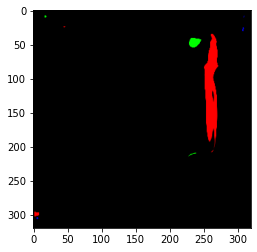

In [222]:
plt.imshow(rearrange(output[0].detach().cpu().numpy(),'c h w -> h w c'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


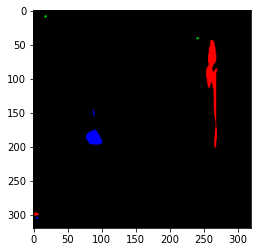

In [223]:
plt.imshow(rearrange(output1[0].detach().cpu().numpy(),'c h w -> h w c'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

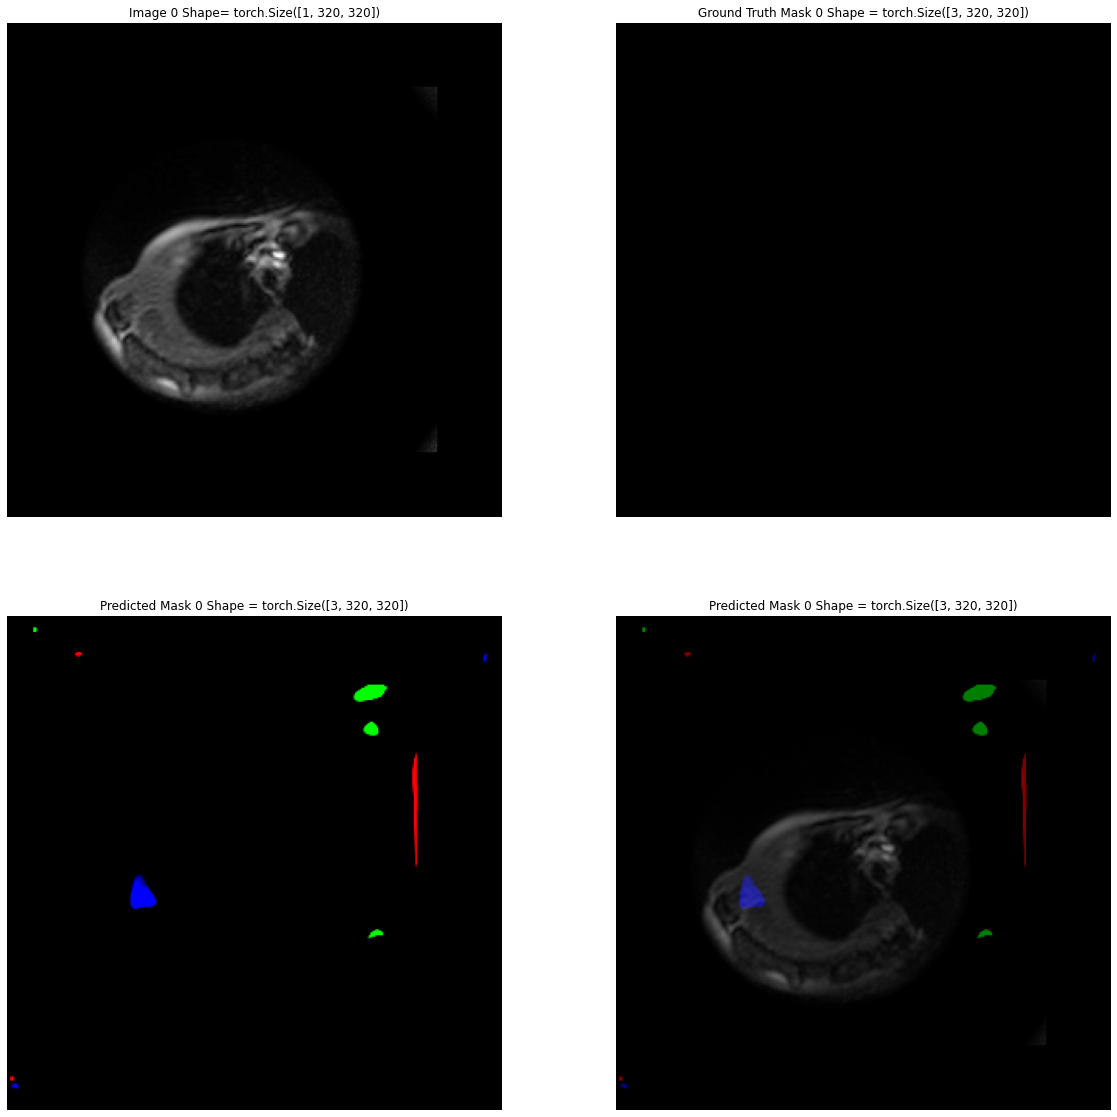

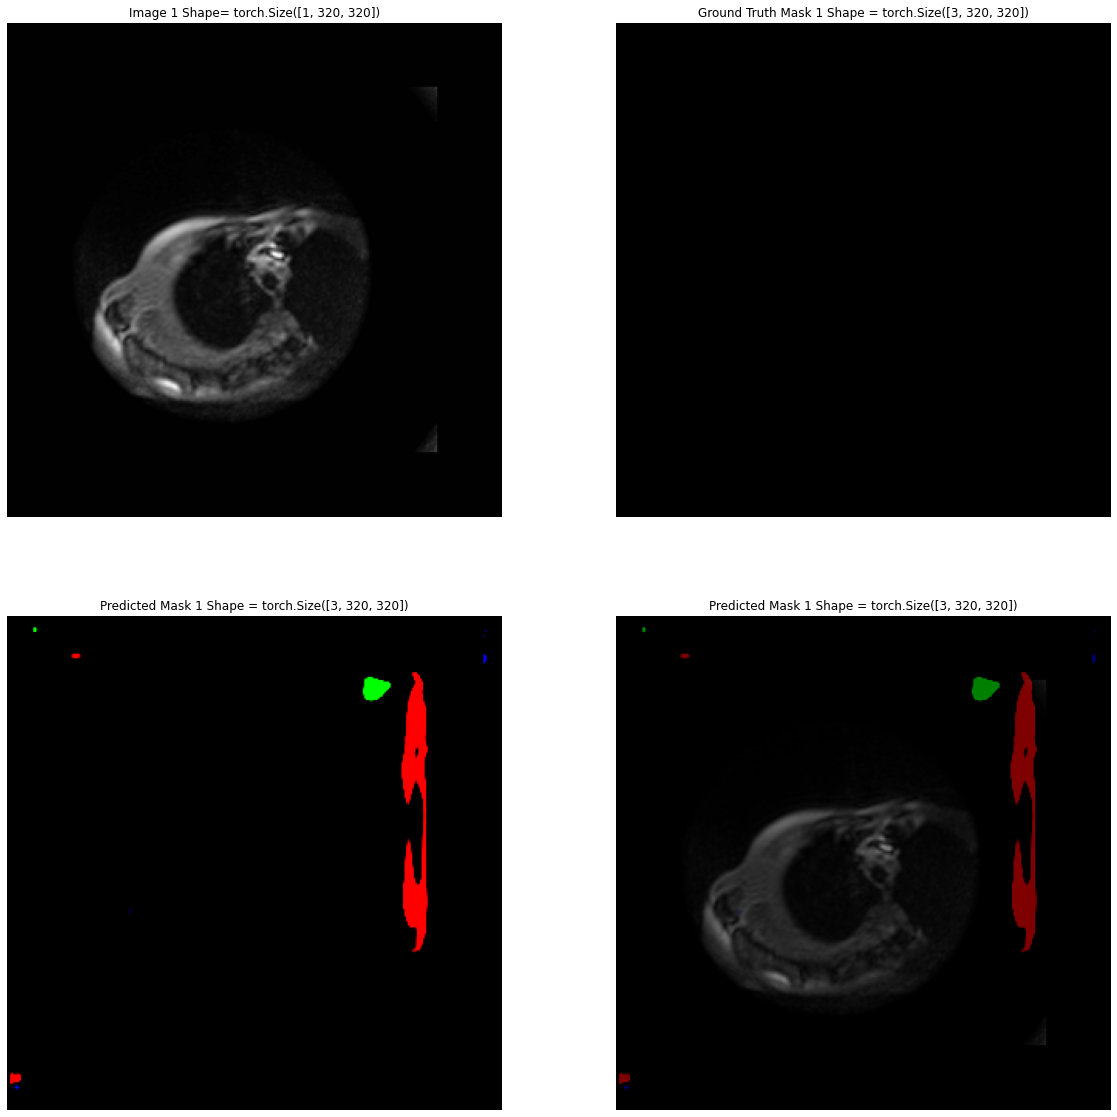

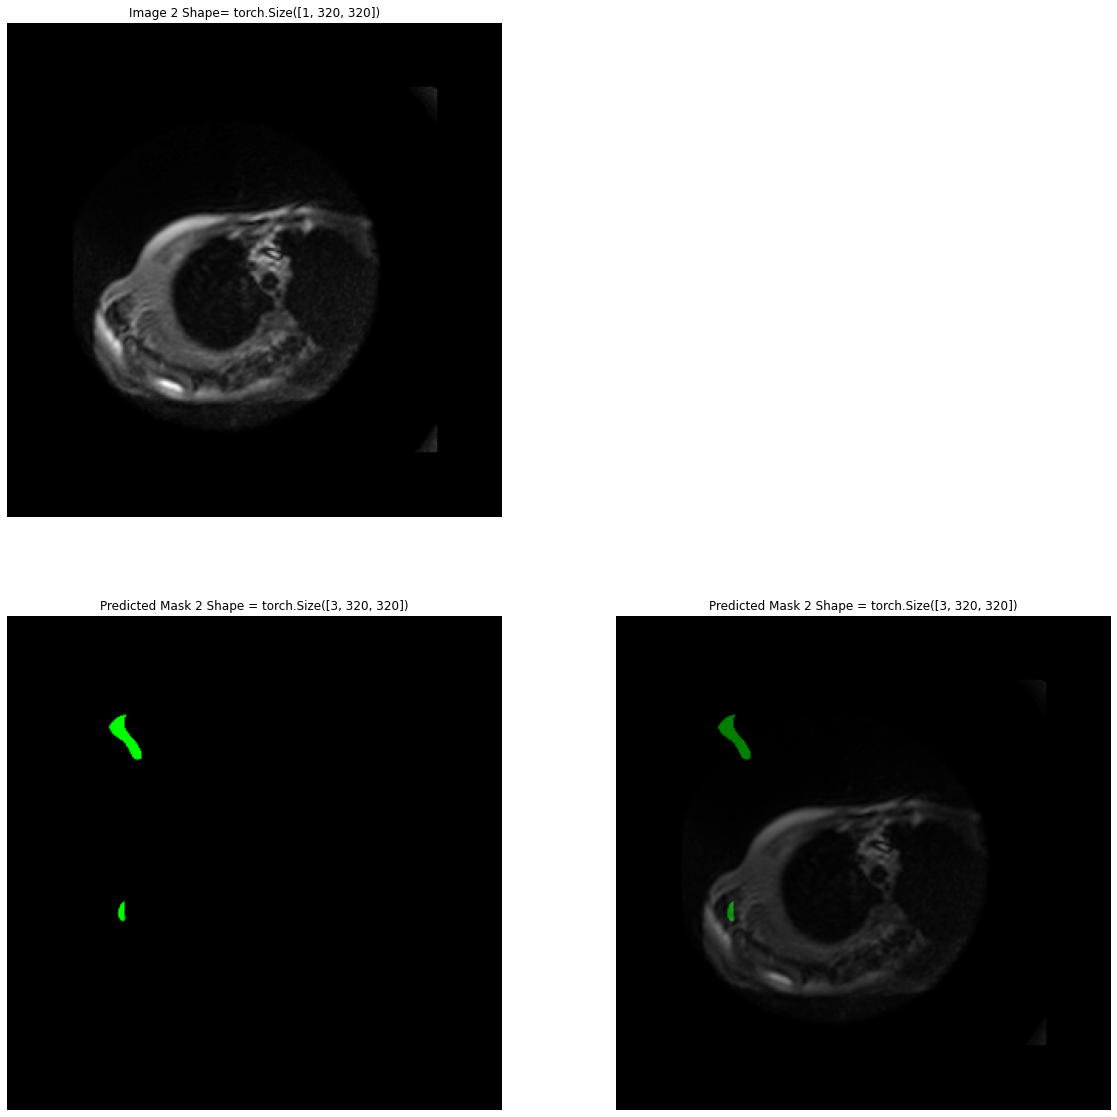

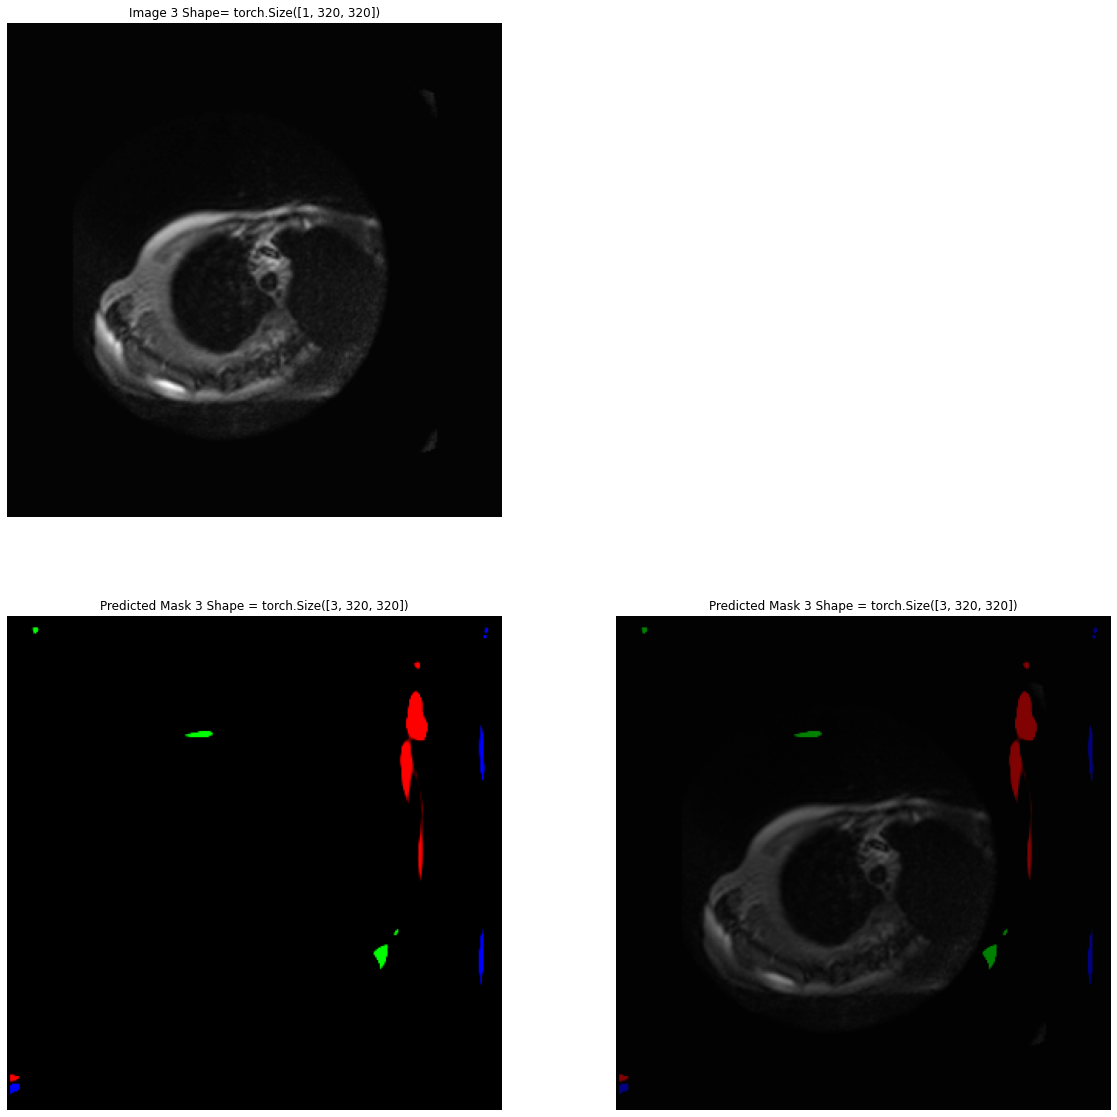

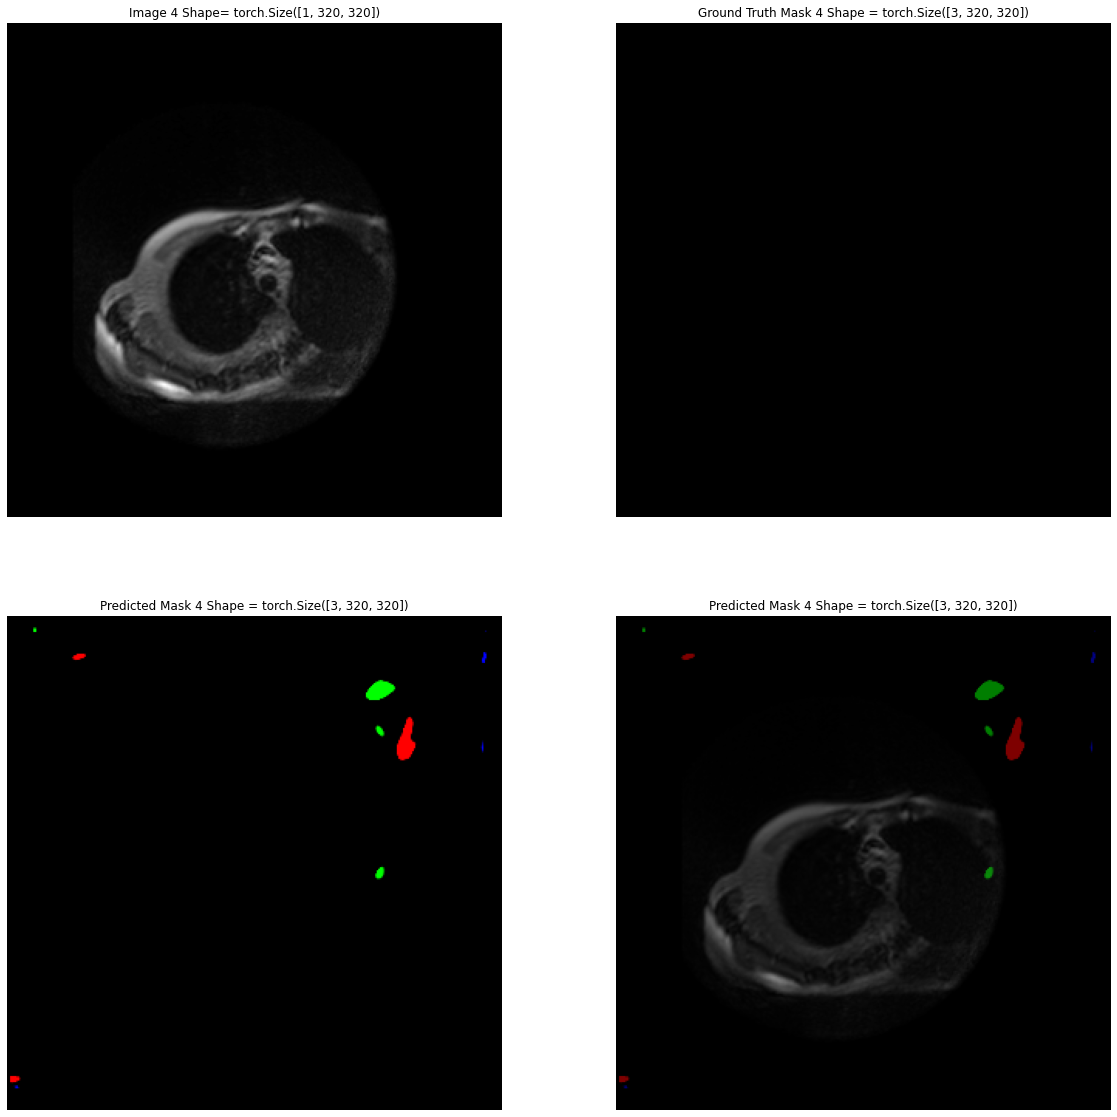

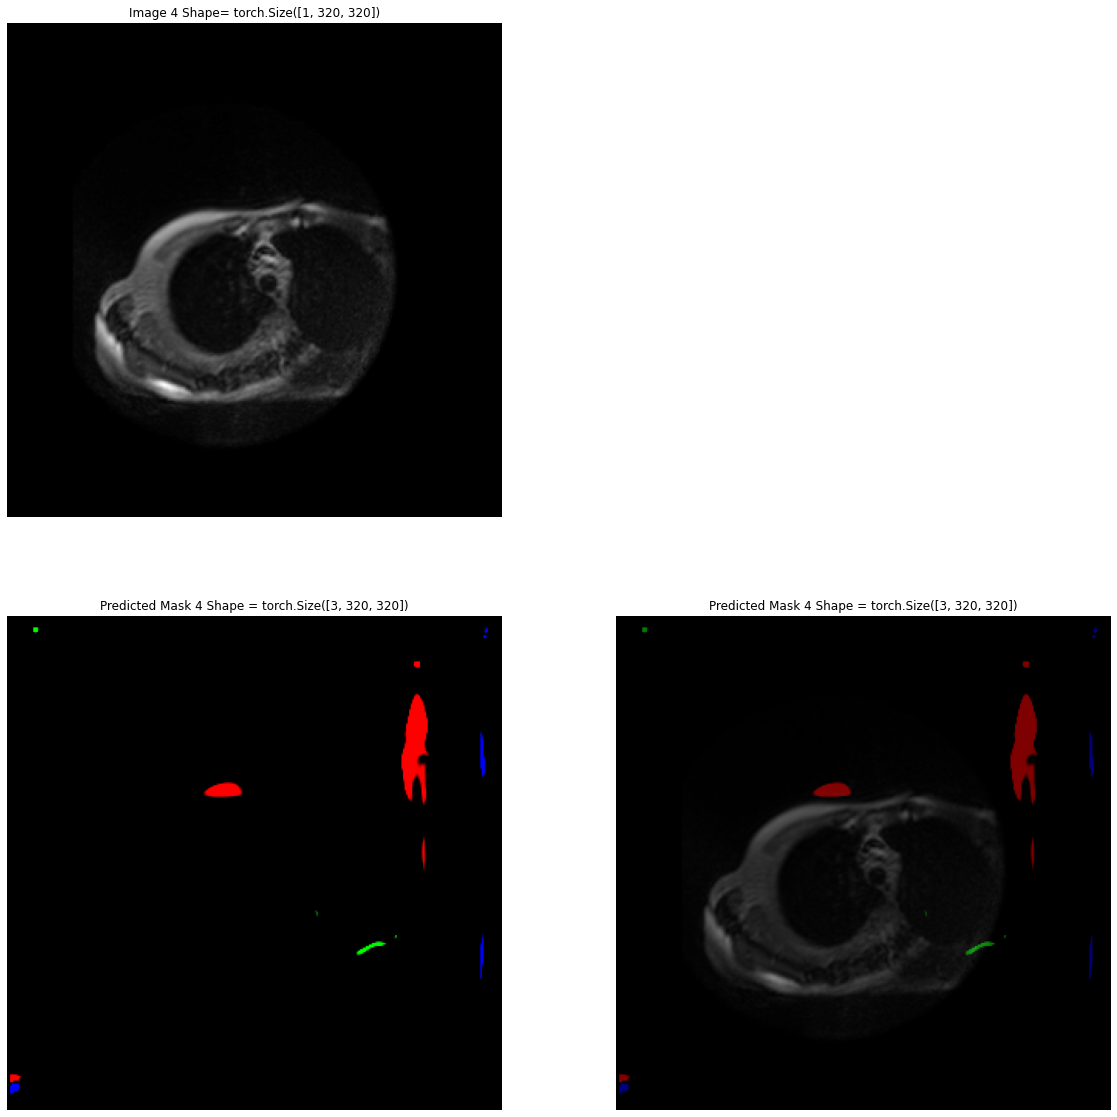

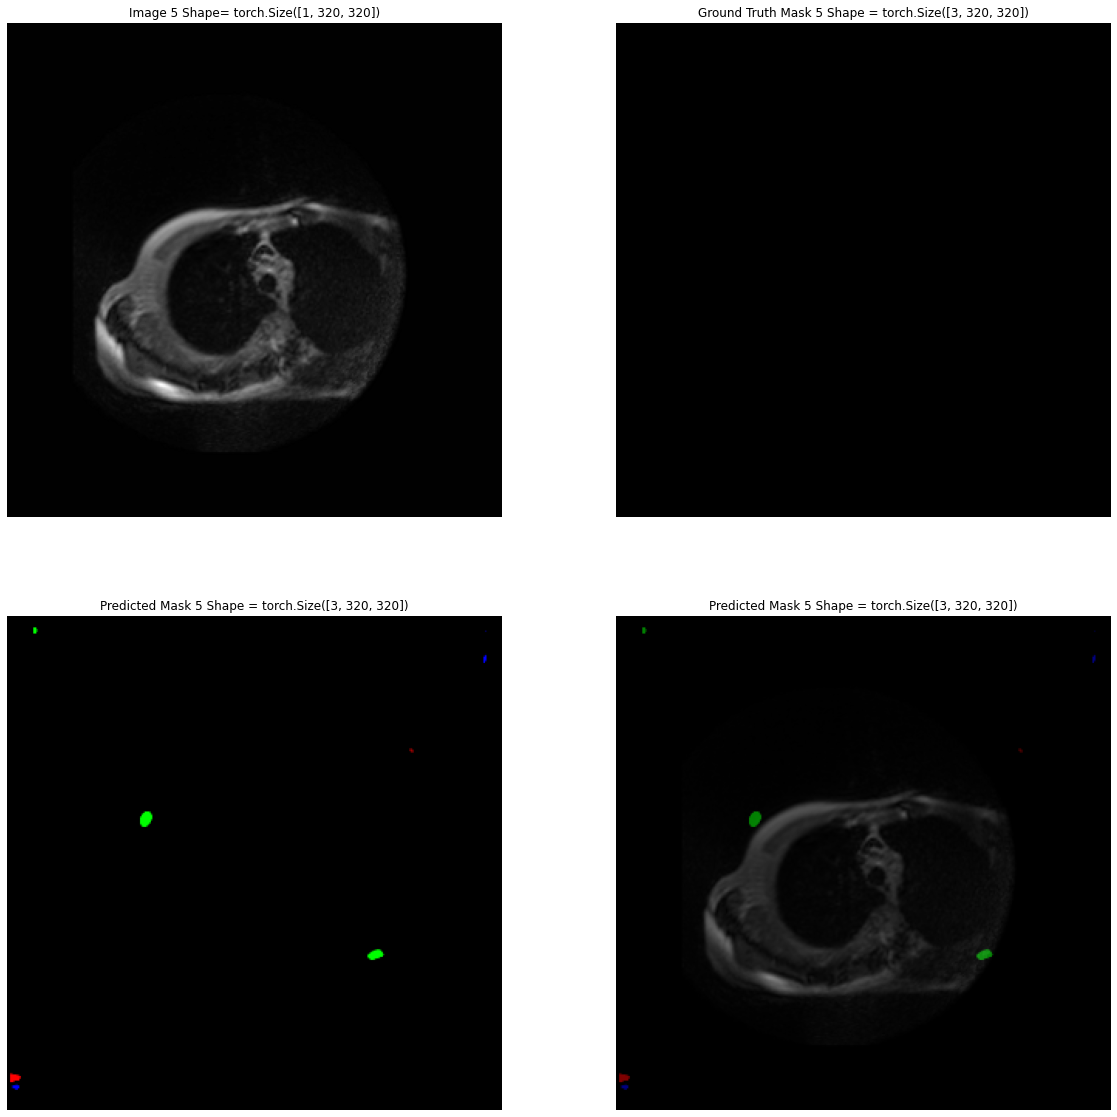

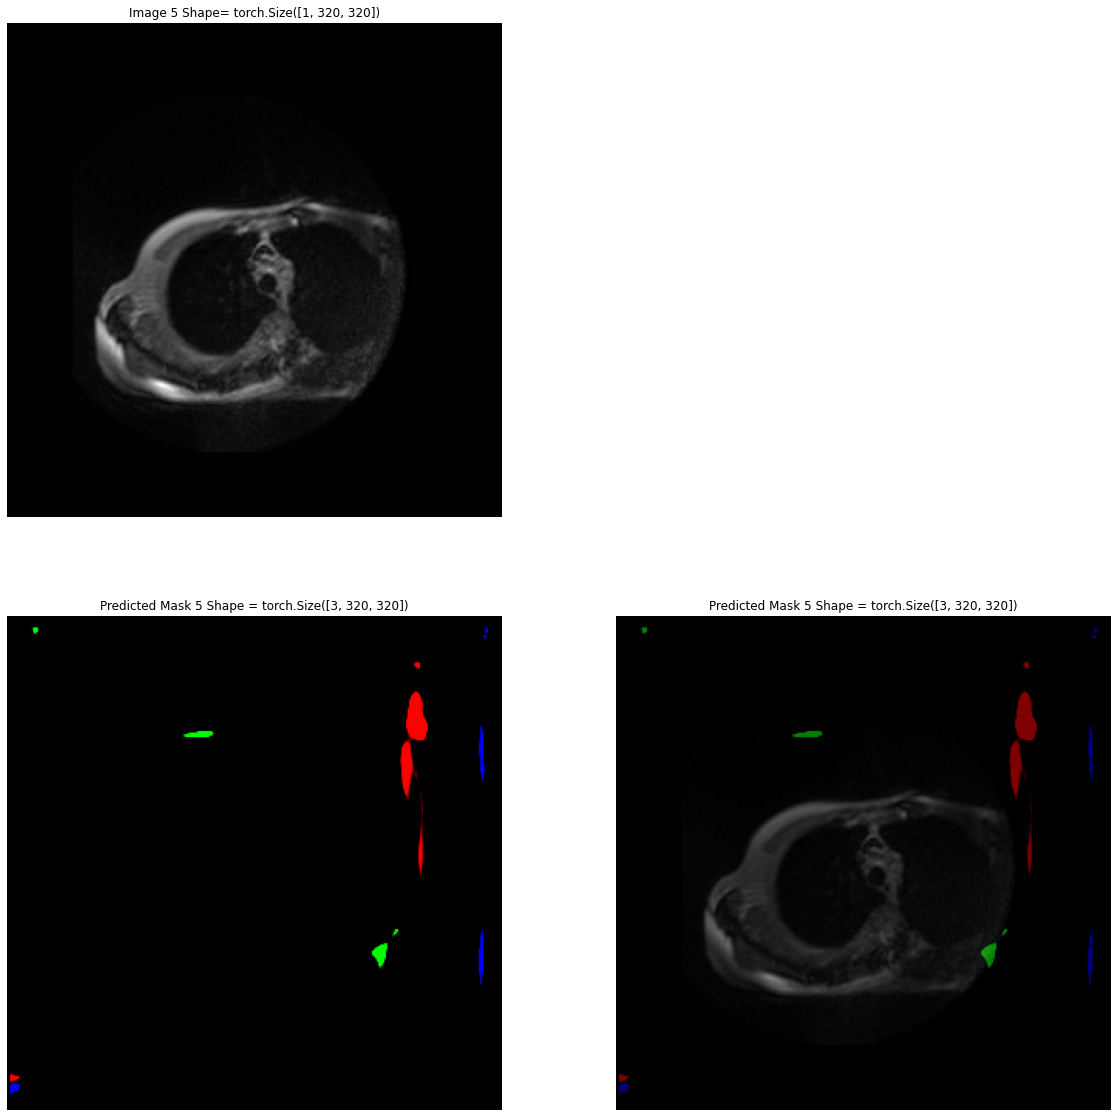

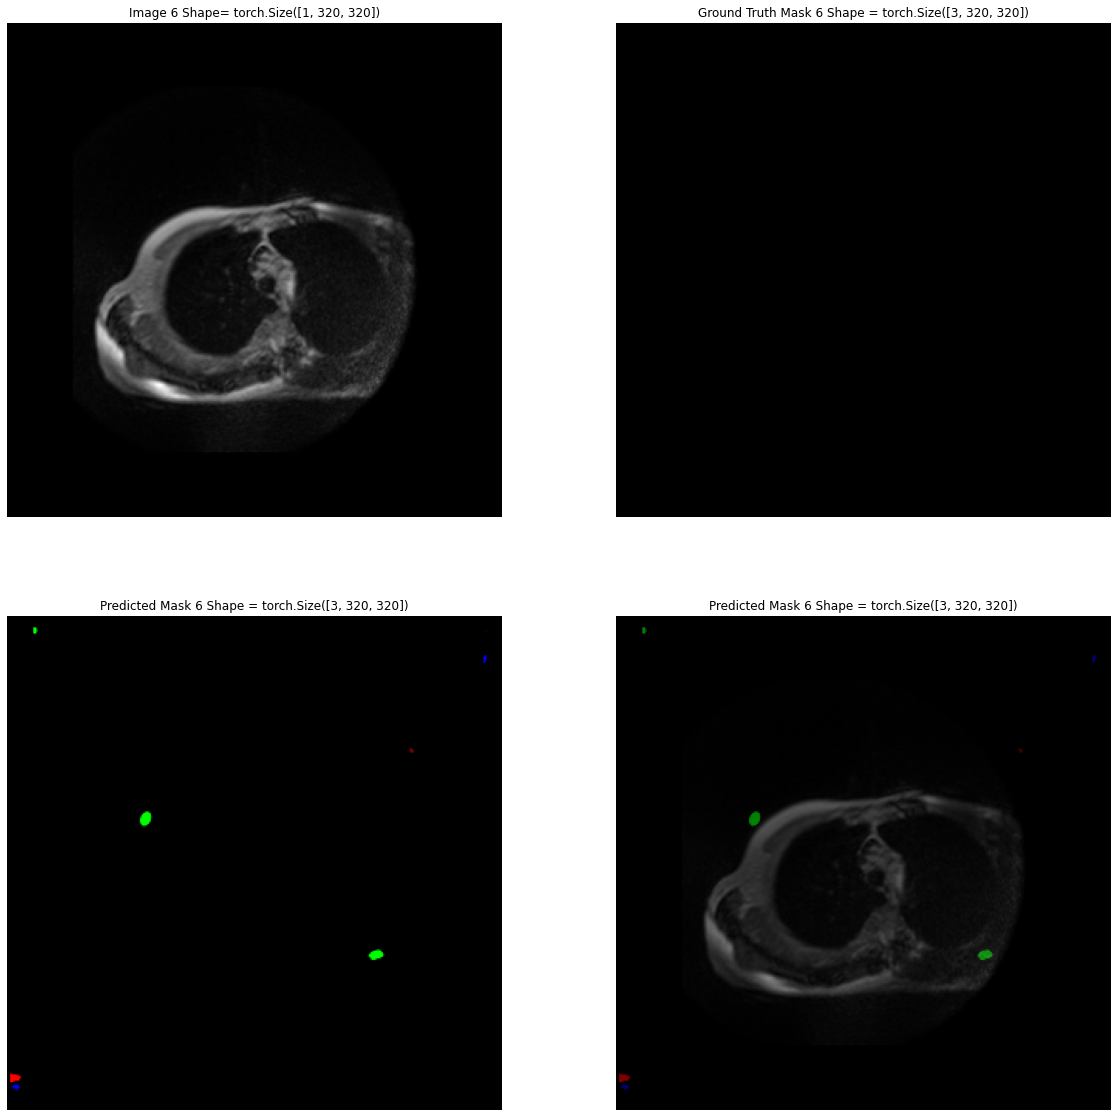

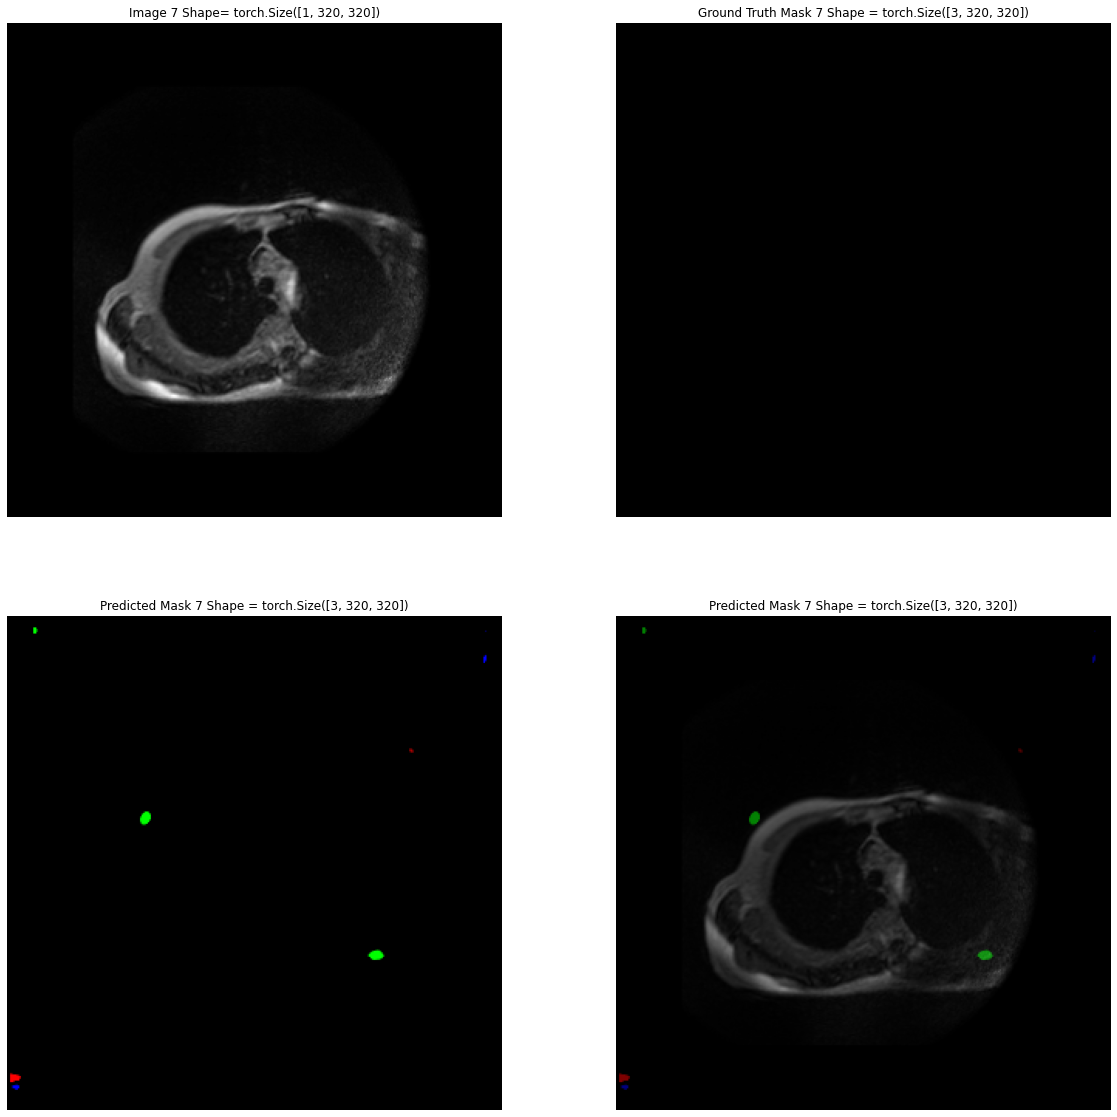

In [206]:
for idx in range(0,8):
    plot_result(data=data, output=output, idx=idx)
    plot_result(data=data1, output=output1, idx=idx)

In [72]:
output = torch.nn.Sigmoid()(output)
output = (output > threshold)*1.0

In [135]:
def plot_result(data,output,idx):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image {idx} Shape= {data['image'][idx].shape}")
    plt.axis('off')
    if 'mask'in data.keys():
        plt.subplot(2,2,2)
        plt.imshow(rearrange(data['mask'][idx].numpy(),'c h w -> h w c'), aspect=ratio)
        plt.title(f"Ground Truth Mask {idx} Shape = {data['mask'][idx].shape}")
        plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), alpha=0.5, aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

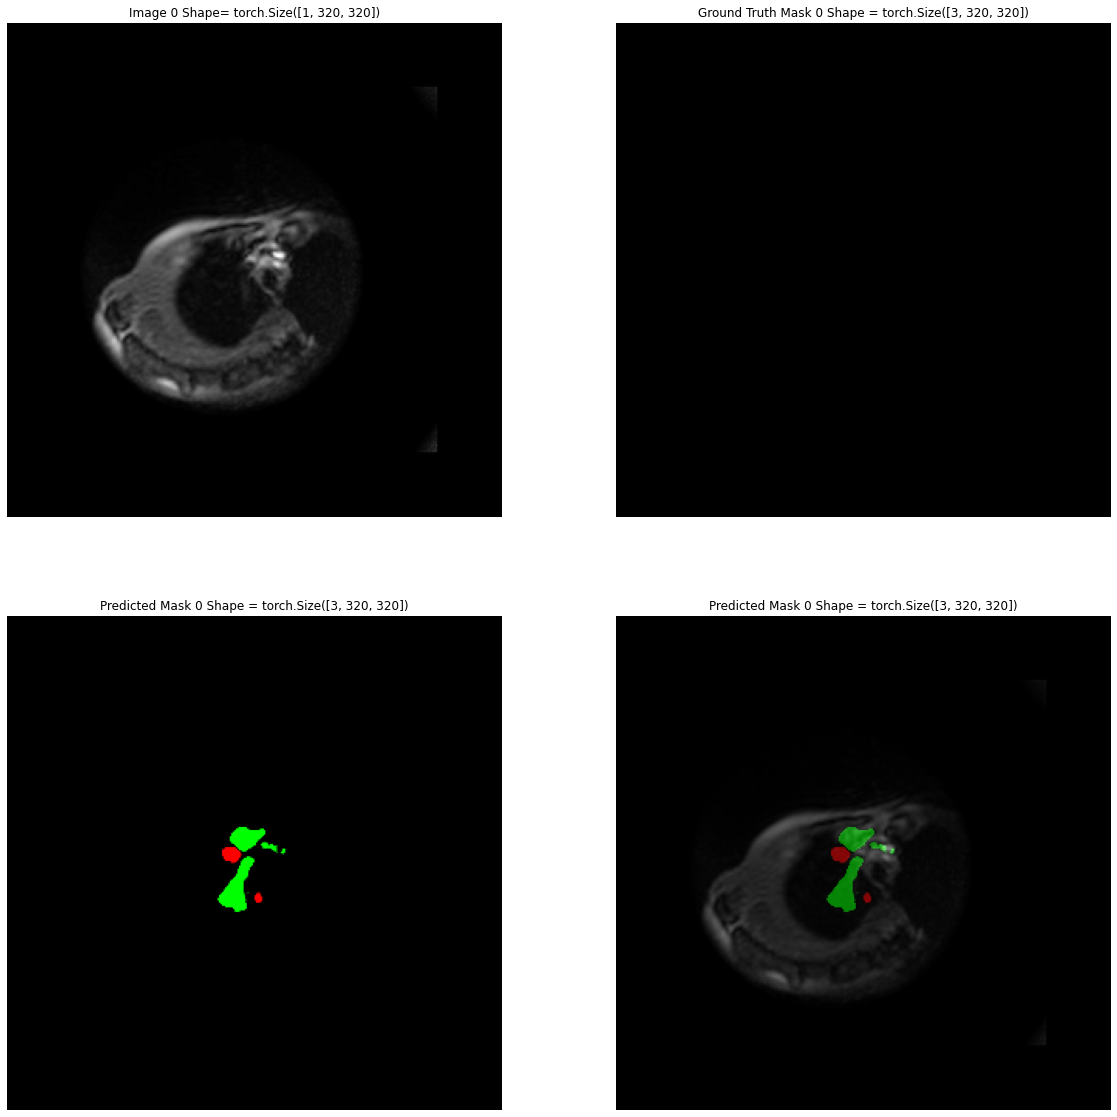

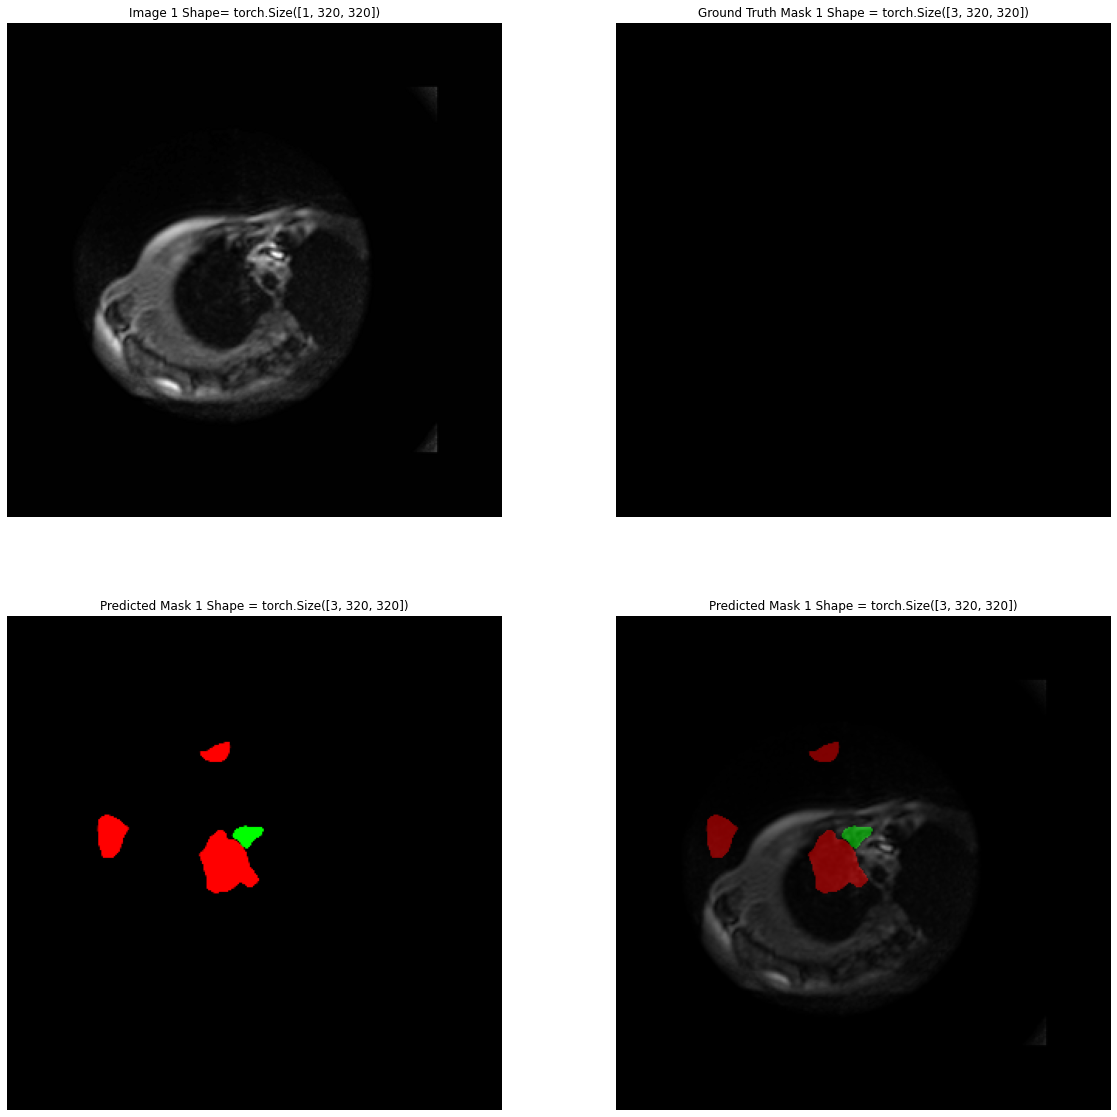

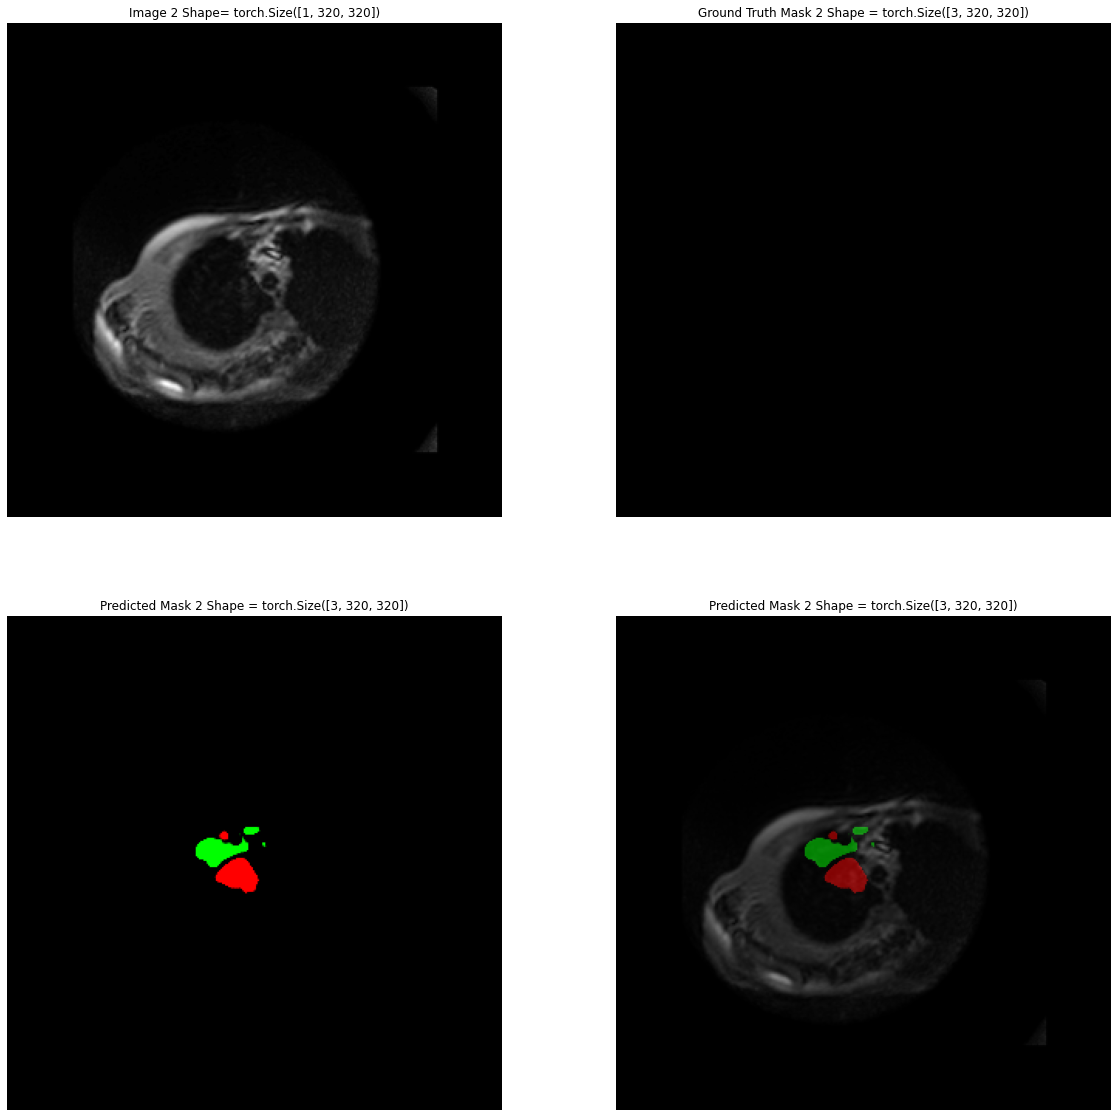

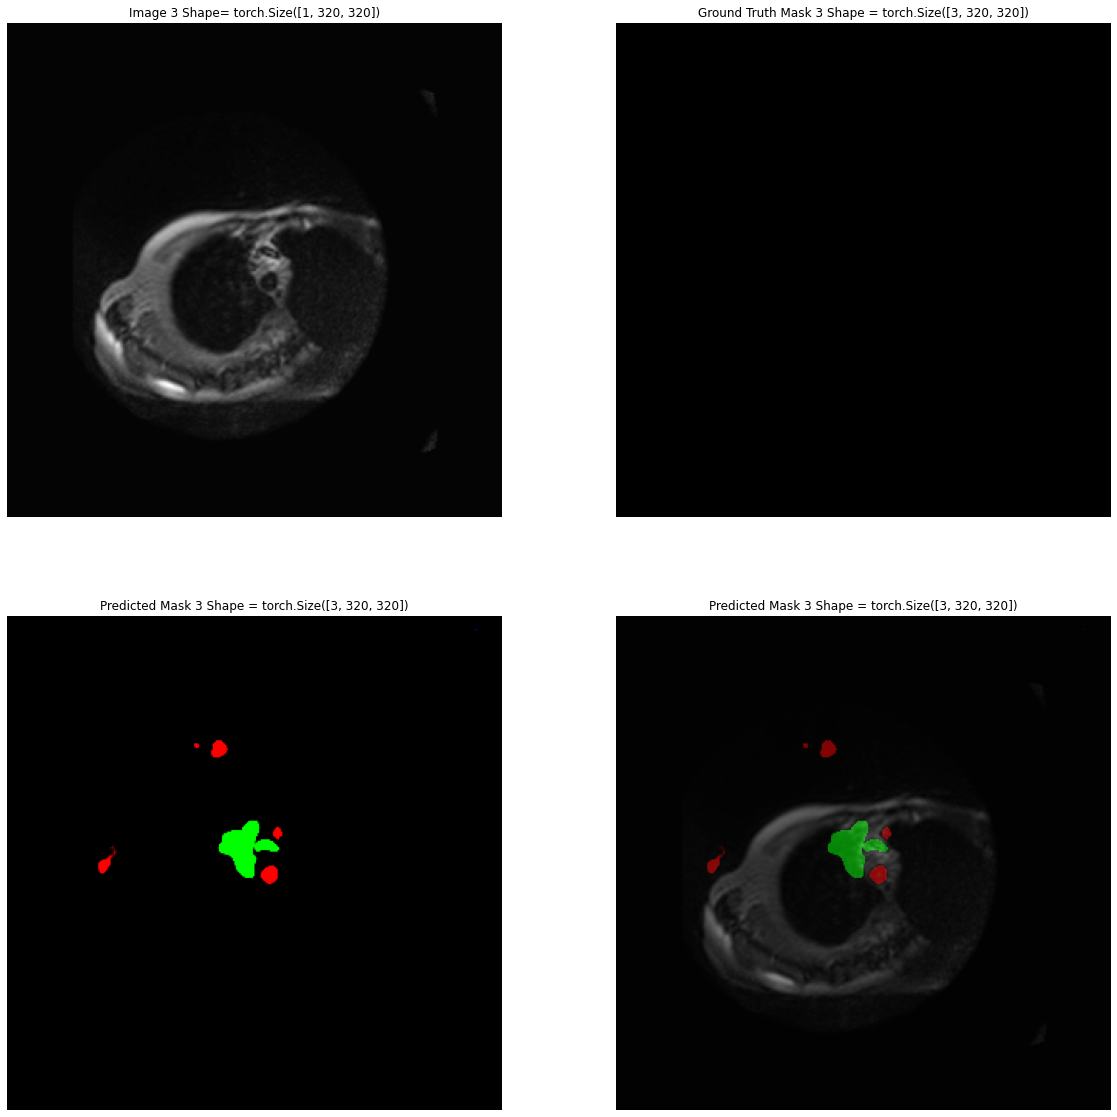

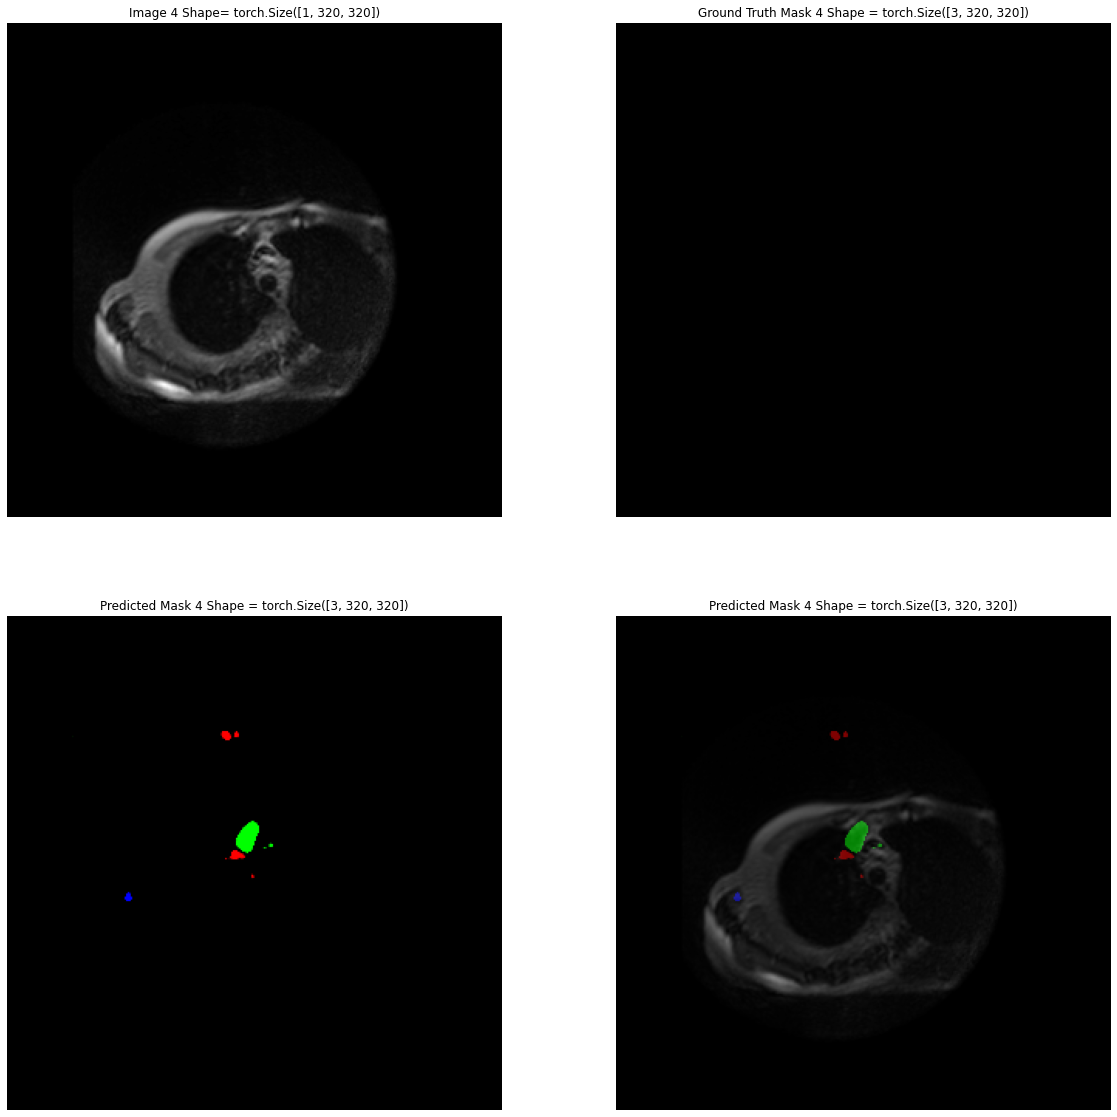

In [141]:
for idx in range(0,8):
    plot_result(data=data, output=output, idx=idx)

test: 0
test: 1
test: 2
test: 3
test: 4
test: 5
test: 6
test: 7
test: 8
test: 9
test: 10
test: 11
test: 12
test: 13
test: 14
test: 15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

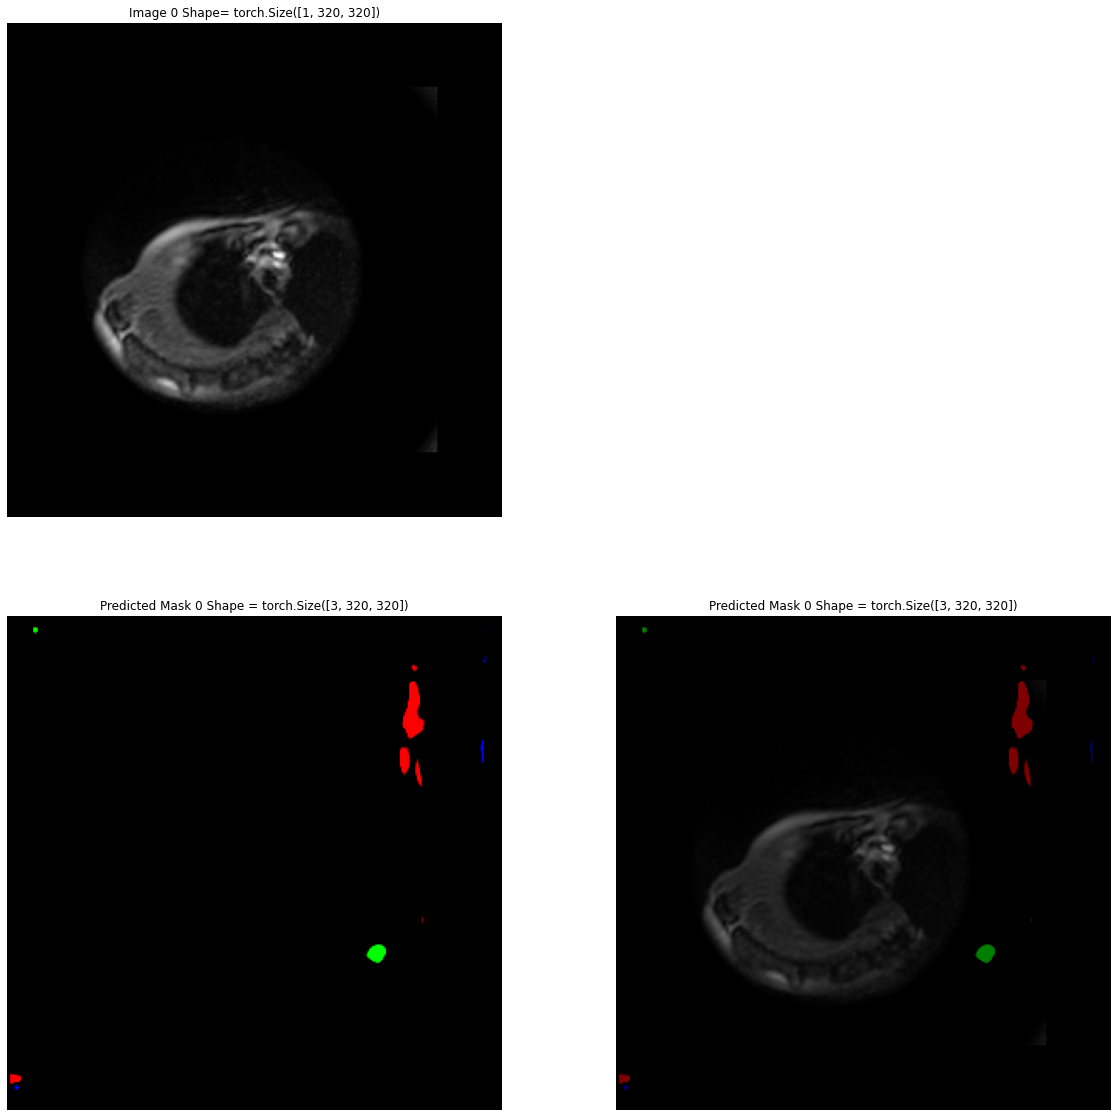

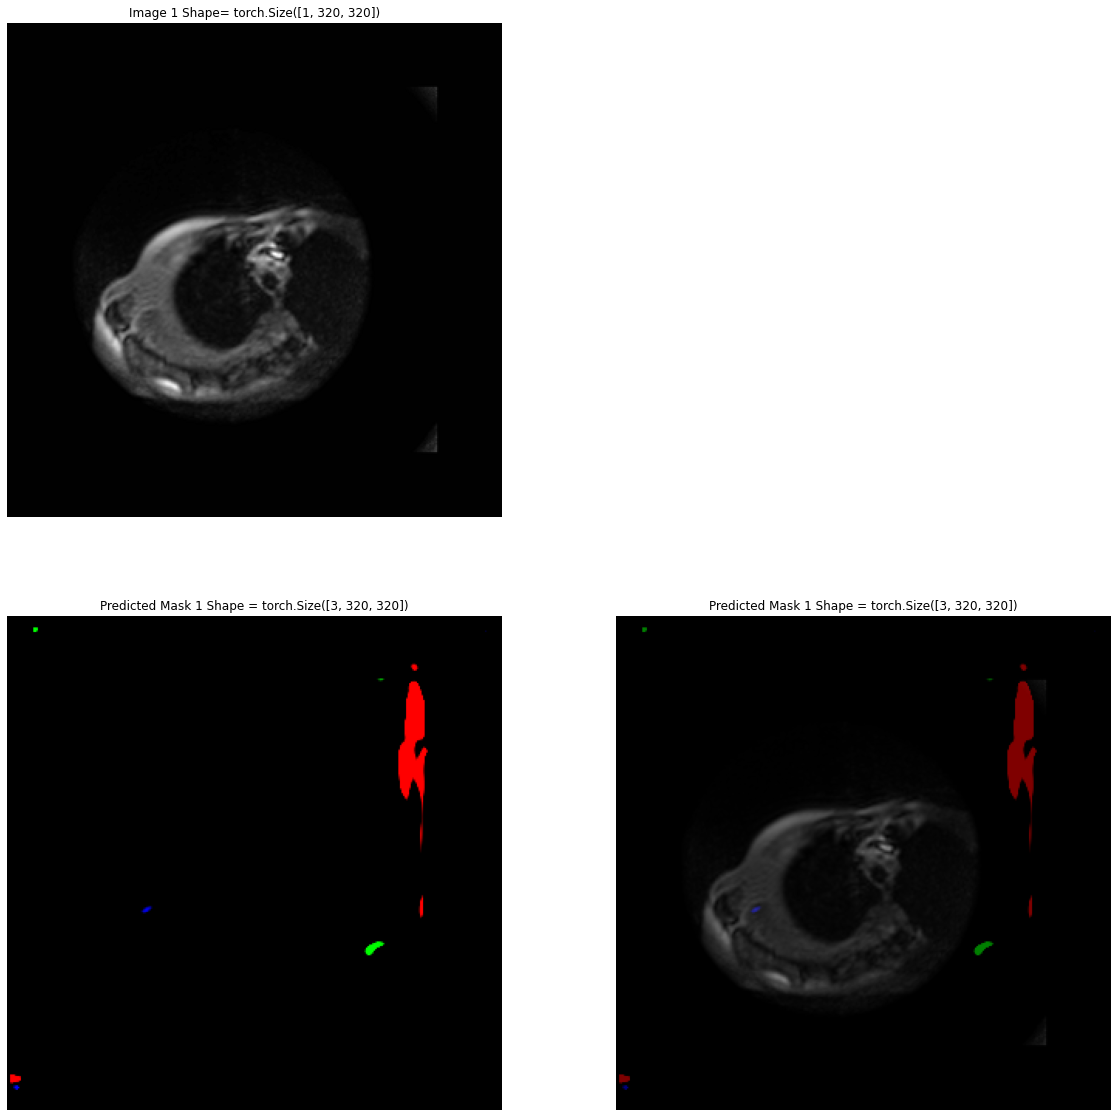

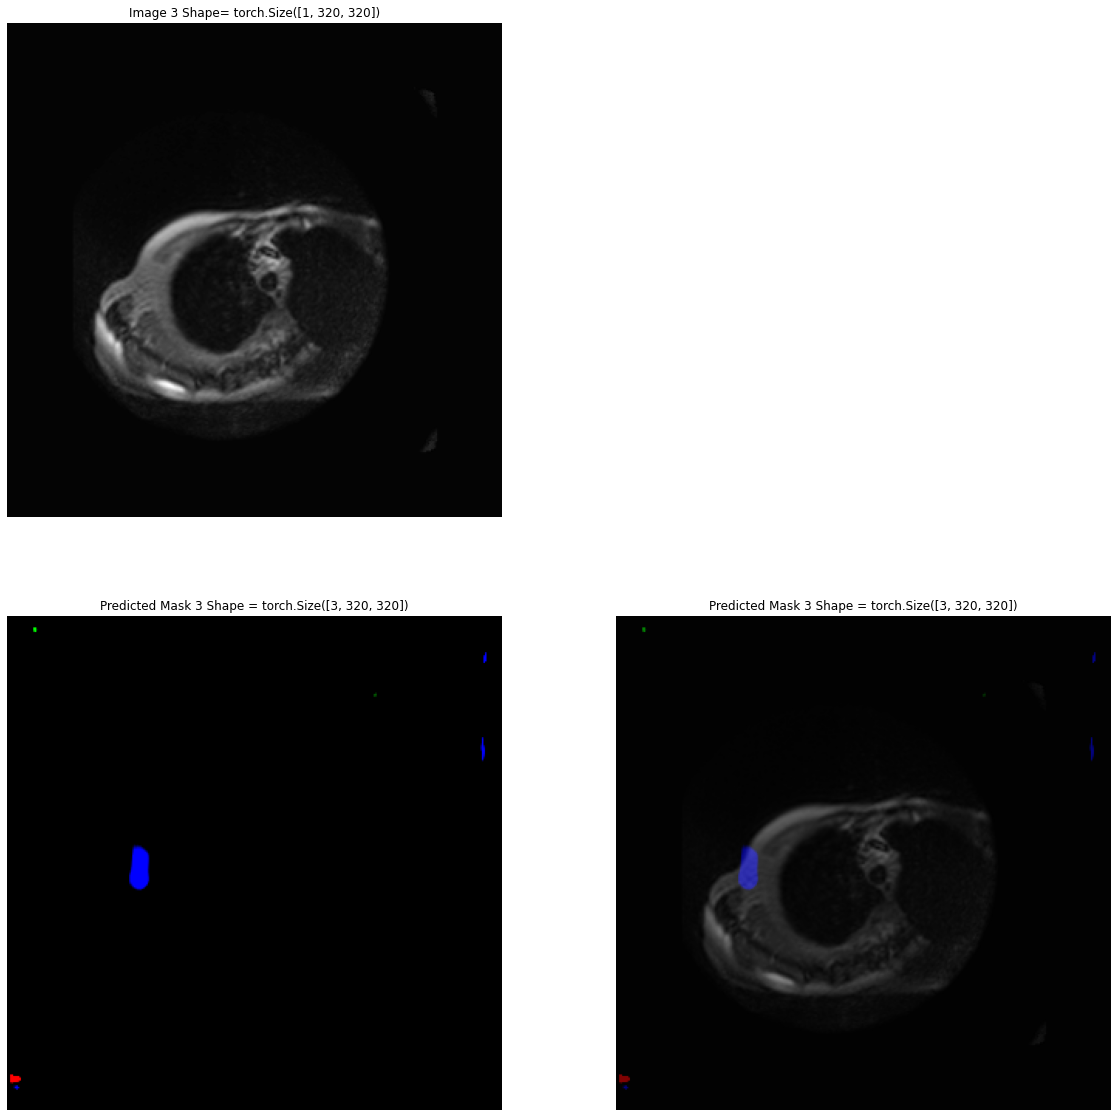

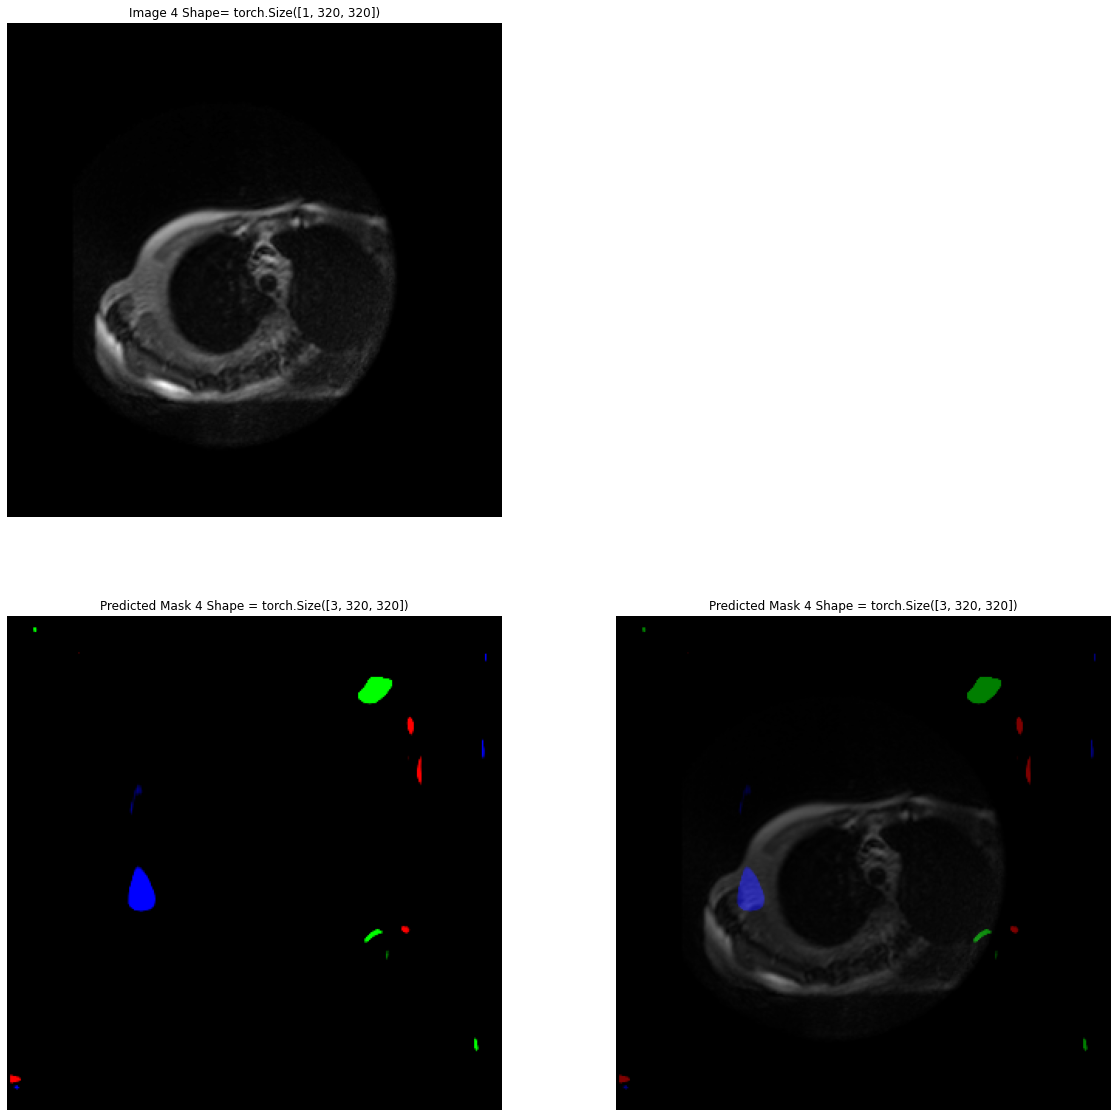

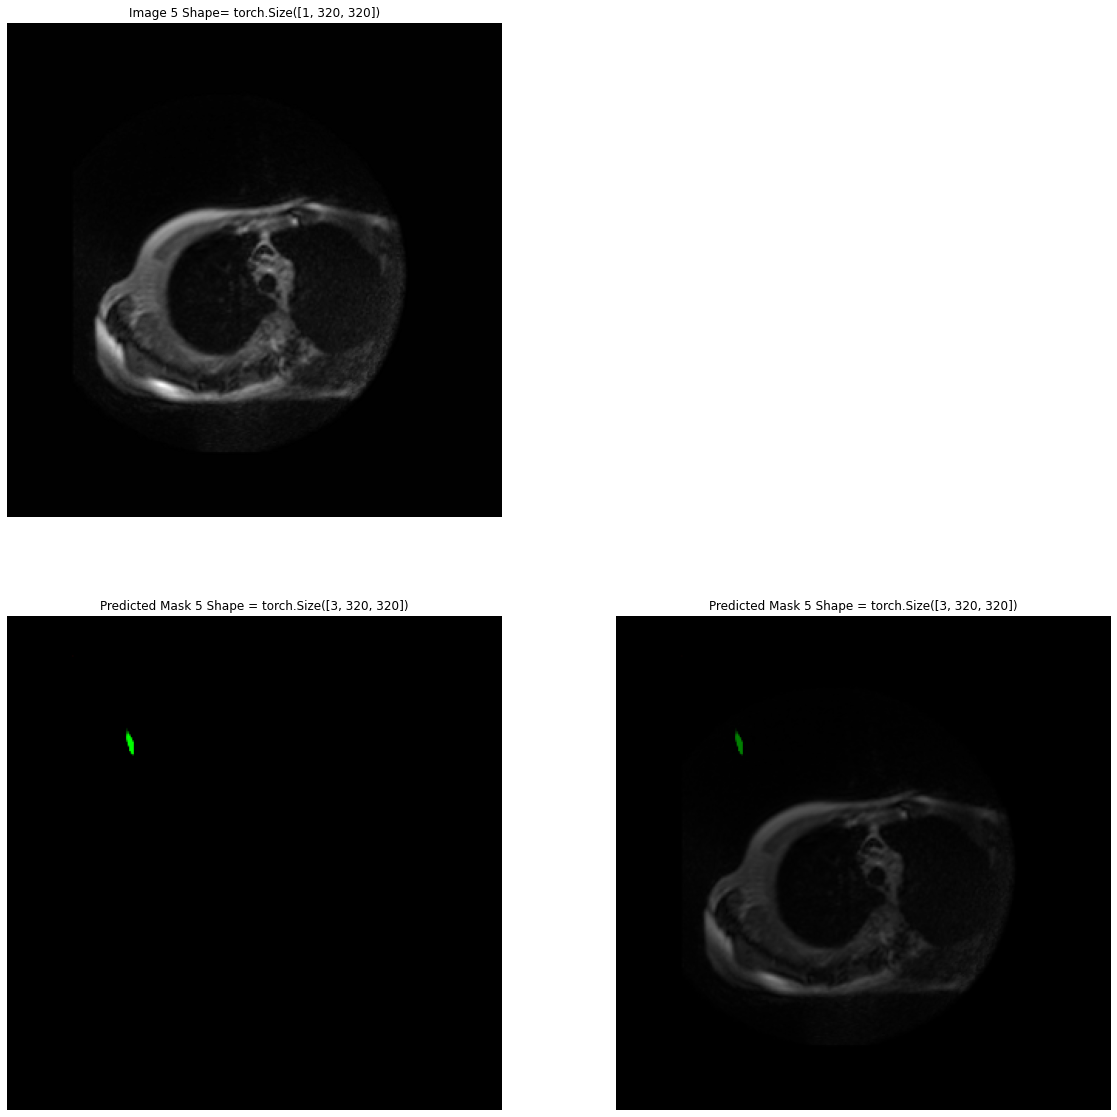

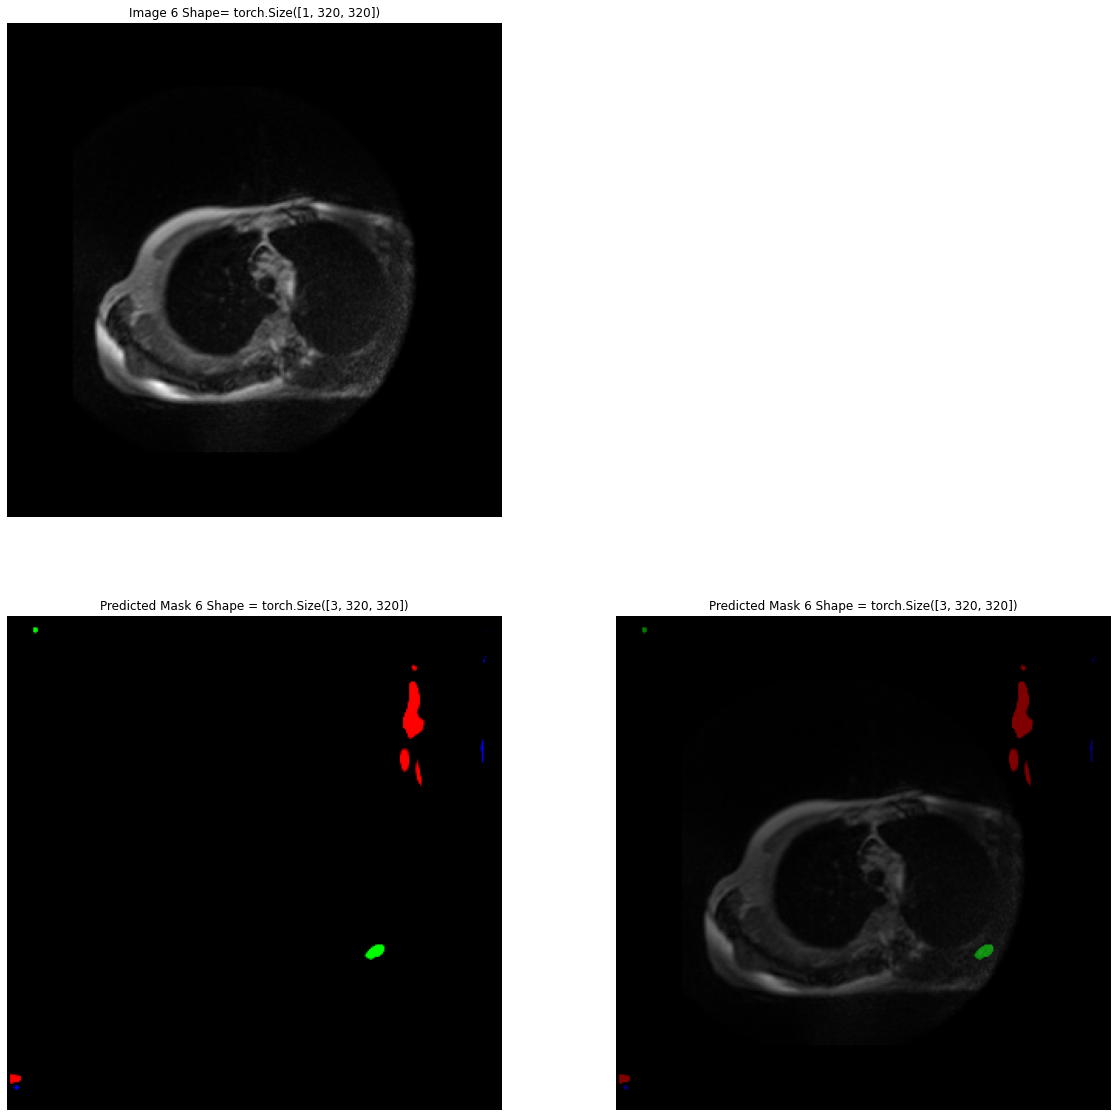

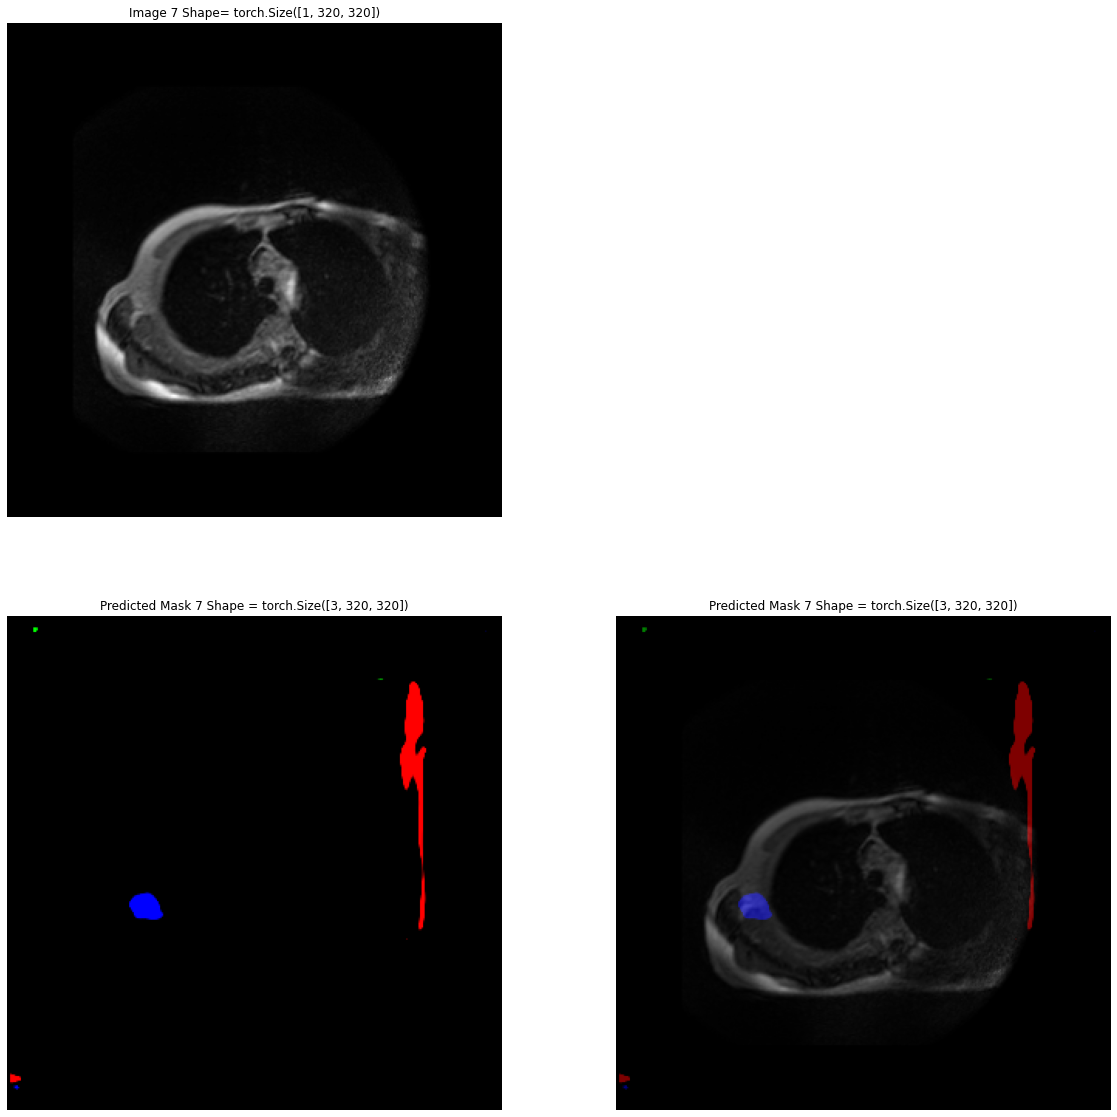

In [138]:
for idx in range(0,8):
    plot_result(data=data, output=output, idx=idx)

In [230]:
df2d.keys()

Index(['Unnamed: 0', 'large_bowel', 'small_bowel', 'stomach', 'id',
       'case_id_str', 'case_id', 'day_num_str', 'day_num', 'slice_id',
       'slice_num', 'match', 'subpath', 'filename', 'im_height', 'im_width',
       'im_pixel_height', 'im_pixel_width', 'slice_thickness', 'segmentations',
       'fold', 'path'],
      dtype='object')

In [260]:
sel = df2d['segmentations']

In [265]:
case_list = df2d[sel]['case_id_str'].drop_duplicates()

In [268]:
case_list.shape[0]

85

In [269]:
df2d['seg2'] = False

In [271]:
for i in range(0,case_list.shape[0]):
    sel = df2d['case_id_str'] == case_list.iloc[i]
    df2d.loc[sel,'seg2'] = True

In [274]:
(df2d['segmentations'] == True).sum()

16590

In [276]:
for c in case_list:
    s = df2d['case_id_str'] == c
    print(c, df2d[s]['segmentations'].sum(), s.sum())
    break


case101 224 576


In [277]:
df2d[s]

Unnamed: 0 large_bowel small_bowel stomach                        id  \
0             0         NaN         NaN     NaN  case101_day20_slice_0001   
1             1         NaN         NaN     NaN  case101_day20_slice_0002   
2             2         NaN         NaN     NaN  case101_day20_slice_0003   
3             3         NaN         NaN     NaN  case101_day20_slice_0004   
4             4         NaN         NaN     NaN  case101_day20_slice_0005   
..          ...         ...         ...     ...                       ...   
571         571         NaN         NaN     NaN  case101_day32_slice_0140   
572         572         NaN         NaN     NaN  case101_day32_slice_0141   
573         573         NaN         NaN     NaN  case101_day32_slice_0142   
574         574         NaN         NaN     NaN  case101_day32_slice_0143   
575         575         NaN         NaN     NaN  case101_day32_slice_0144   

    case_id_str  case_id day_num_str  day_num    slice_id  ...  \
0       case101      101       day20       20  slice_0001  ...   
1       case101      101       day20       20  slice_0002  ...   
2       case101      101       day20       20  slice_0003  ...   
3       case101      101       day20       20  slice_0004  ...   
4       case101      101       day20       20  slice_0005  ...   
..          ...      ...         ...      ...         ...  ...   
571     case101      101       day32       32  slice_0140  ...   
572     case101      101       day32       32  slice_0141  ...   
573     case101      101       day32       32  slice_0142  ...   
574     case101      101       day32       32  slice_0143  ...   
575     case101      101       day32       32  slice_0144  ...   

                             filename im_height im_width im_pixel_height  \
0    slice_0001_266_266_1.50_1.50.png       266      266             1.5   
1    slice_0002_266_266_1.50_1.50.png       266      266             1.5   
2    slice_0003_266_266_1.50_1.50.png       266      266             1.5   
3    slice_0004_266_266_1.50_1.50.png       266      266             1.5   
4    slice_0005_266_266_1.50_1.50.png       266      266             1.5   
..                                ...       ...      ...             ...   
571  slice_0140_266_266_1.50_1.50.png       266      266             1.5   
572  slice_0141_266_266_1.50_1.50.png       266      266             1.5   
573  slice_0142_266_266_1.50_1.50.png       266      266             1.5   
574  slice_0143_266_266_1.50_1.50.png       266      266             1.5   
575  slice_0144_266_266_1.50_1.50.png       266      266             1.5   

     im_pixel_width  slice_thickness  segmentations  fold  \
0               1.5              3.0          False   4.0   
1               1.5              3.0          False   4.0   
2               1.5              3.0          False   4.0   
3               1.5              3.0          False   4.0   
4               1.5              3.0          False   4.0   
..              ...              ...            ...   ...   
571             1.5              3.0          False   4.0   
572             1.5              3.0          False   4.0   
573             1.5              3.0          False   4.0   
574             1.5              3.0          False   4.0   
575             1.5              3.0          False   4.0   

                                                  path  seg2  
0    /media/SSD/gi-tract/uw-madison-gi-tract-image-...  True  
1    /media/SSD/gi-tract/uw-madison-gi-tract-image-...  True  
2    /media/SSD/gi-tract/uw-madison-gi-tract-image-...  True  
3    /media/SSD/gi-tract/uw-madison-gi-tract-image-...  True  
4    /media/SSD/gi-tract/uw-madison-gi-tract-image-...  True  
..                                                 ...   ...  
571  /media/SSD/gi-tract/uw-madison-gi-tract-image-...  True  
572  /media/SSD/gi-tract/uw-madison-gi-tract-image-...  True  
573  /media/SSD/gi-tract/uw-madison-gi-tract-image-...  True  
574  /media

In [124]:
::::::::::::::::::::::::::::::::::

SyntaxError: invalid syntax (736381564.py, line 1)

In [26]:
ROOT_FOLDER + 'train_sub_gpu2.csv'

'/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train_sub_gpu2.csv'

In [27]:
sub_df.to_csv(ROOT_FOLDER + 'train_sub_gpu2.csv', index = False)